In [1]:
import os
os.chdir('../')

In [2]:
device = 'cpu'

In [3]:
import numpy as np
import argparse
import time
from itertools import chain
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR
from sr_model.utils import get_sr, plot_in_rings

## Set RBYCacheWalk dataset parameters

In [69]:
# Dataset Configs
dataset = inputs.RBYCacheWalk(
    num_spatial_states=17, downsample_factor=None, skip_frame=None,
    vel_thresh=4, event_window=7, set_to_wedges=True
    )

In [70]:
wedge_states, cache_interactions = dataset.get_rel_vars()

## Initialize Network

In [71]:
# Init net
net = AnalyticSR(num_states=dataset.num_states, gamma=0.7)

## Run network and get learned M

In [72]:
# Make input
dg_inputs = torch.from_numpy(dataset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dataset.dg_modes.T).float().to(device).unsqueeze(1)

with torch.no_grad():
    _, outputs = net(dg_inputs, dg_modes)

In [73]:
M = get_sr(net.ca3.get_T(), 0.99)

## Plot function

In [5]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import matplotlib.patches as patches

(0, 1.2)

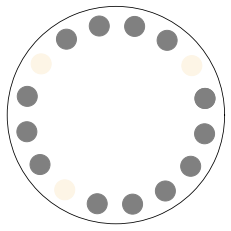

In [9]:
# For generating explanatory graphics
fig = plt.figure()
colors = ['gray']*17

#colors[1] = 'red'

# colors[3] = colors[5] = 'lightsalmon'
# colors[2] = colors[6] = 'peachpuff'
#colors[11:15] = ['gray']*len(colors[11:15])
#colors[1] = colors[7] = 'oldlace'

colors[1] = colors[10] = colors[6] = 'oldlace'

#colors[-2] = 'blue'

ax = fig.add_subplot(projection='polar')
ax.scatter(
    np.linspace(0, 2*pi, 17) + (pi)/17,
    np.ones(17),
    c=colors,
    s=400
    )
plt.xticks([])
plt.yticks([])
plt.ylim((0,1.2))

In [86]:
def plot_in_rings(state_vector, input, title, save_title=None):
    spatial_mat, context_mat = input.unravel_state_vector(state_vector)
    spatial_mat = spatial_mat[:-1].reshape((-1, 1))
    vmax = np.max([spatial_mat.max(), context_mat.max()])
    if vmax == 0:
        vmax = 1
    wedge_states, cache_interactions = input.get_rel_vars()
    
    ax1 = plt.subplot(2, 1, 1, projection='polar')
    ax2 = plt.subplot(2, 1, 2, projection='polar')
    
    spatial_mat = (spatial_mat).squeeze()
    context_mat = (context_mat).squeeze()

    reps = 3
    rad = linspace(0,2*pi, 16*reps, endpoint=True)
    azm = linspace(0.7,1, 16, endpoint=True)
    r, th = meshgrid(rad,azm)
    z_space = np.tile(np.repeat(spatial_mat,reps), (16,1))
    z_context = np.tile(np.repeat(context_mat,reps), (16,1))
    ax1.pcolormesh(r, th, z_space, vmin=0, vmax=vmax)
    ax2.pcolormesh(r, th, z_context, vmin=0, vmax=vmax)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax2.set_xticks([]); ax2.set_yticks([])
    ax1.set_title('Navigation Context')
    ax2.set_title('Cache Context')
    plt.tight_layout()
    #plt.suptitle(title)

#     for cache, interaction_amt in enumerate(cache_interactions):
#         if interaction_amt == 0: continue
#         anchor_point = np.unravel_index([wedge_states[cache]], context_mat.shape)
#         anchor_point = [anchor_point[1] - 0.5, anchor_point[0] - 0.5]
#         rect1 = patches.Rectangle(
#             anchor_point, 1, 1, linewidth=1.5, edgecolor='red', facecolor='none'
#             )
#         ax.add_patch(rect1)
        
    if save_title is not None:
        plt.savefig(f'{save_title}.png', dpi=500)
        #plt.savefig(f'{save_title}.pdf', dpi=500)
    plt.show()

## Plot Query

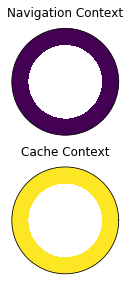

In [87]:
query = np.zeros(dataset.num_states)
query[-16:] = 1
save_title = f'episode_query'
plot_in_rings(
    query, dataset, "SR Query Input",
    save_title=save_title
    )

## Plot Place Cells

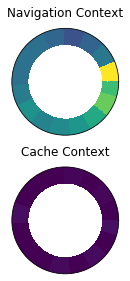

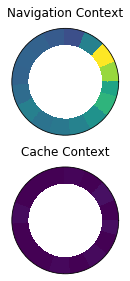

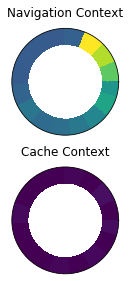

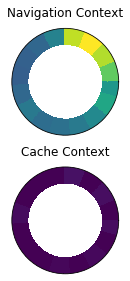

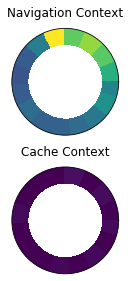

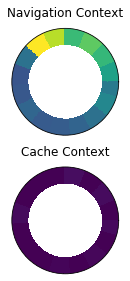

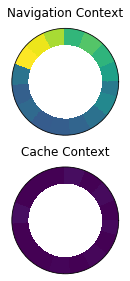

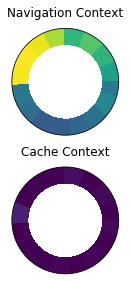

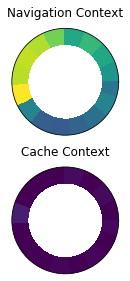

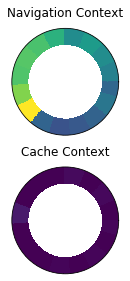

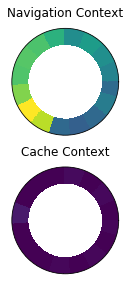

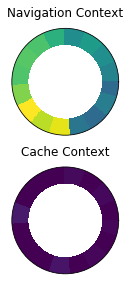

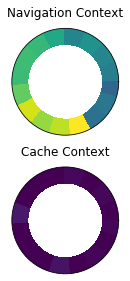

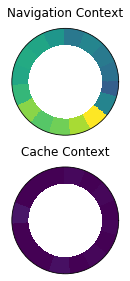

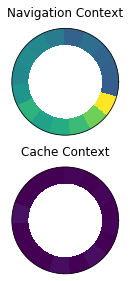

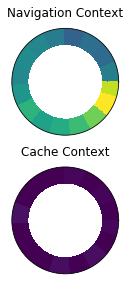

In [88]:
wedge_states, cache_interactions = dataset.get_rel_vars()
for idx, wedge in enumerate(wedge_states):
    query = np.zeros(dataset.num_states)
    query[wedge] = 1
    sr_output = M.T @ query
    if True: #idx in [5, 9]:
        save_title = f'episode_sim_p{idx}'
    else:
        save_title = None
    plot_in_rings(
        sr_output, dataset, "SR from Wedge %s: $M^Ti_{spatial}$"%wedge,
        save_title=save_title
        )

## Plot Episode Cells

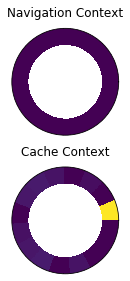

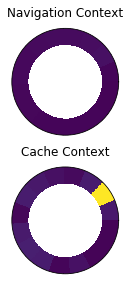

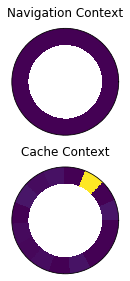

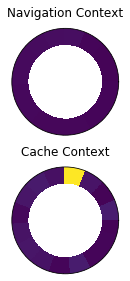

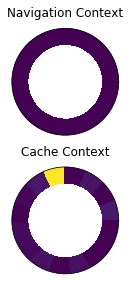

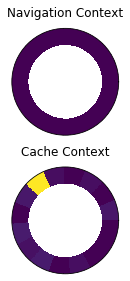

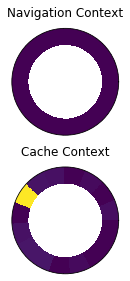

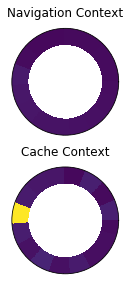

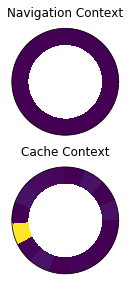

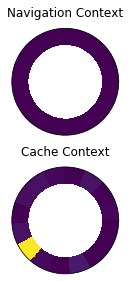

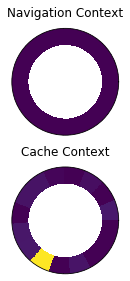

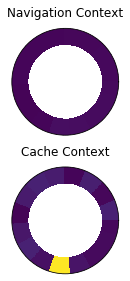

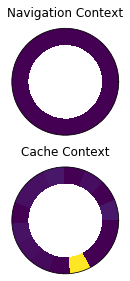

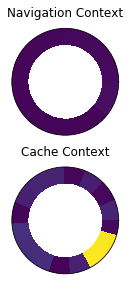

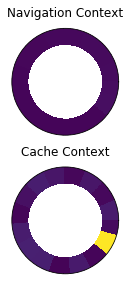

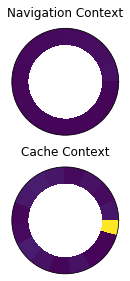

In [89]:
for cache in np.arange(16):
    query = np.zeros(dataset.num_states)
    query[-(16-cache)] = 1
    sr_output = M @ query
    if True: #cache in [5]:
        save_title = f'episode_sim_c{cache}'
    else:
        save_title = None
    plot_in_rings(
        sr_output, dataset, "SR from Cache-site %s: $M^Ti_{cache}$"%cache,
        save_title=save_title
        )